In [11]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal

from collections import defaultdict
from tqdm import tqdm
import pickle as pkl

pyro.set_rng_seed(101)


In [3]:
data = pkl.load(
    open("/data/pinello/PROJECTS/2022_PPIseq/data/1028/1028_pyro_dict.pkl", "rb")
)
print(data.keys())


dict_keys(['reads_edited', 'reads_unedited', 'size_factors', 'fit_dispersions', 'q_design_matrix', 'pi_design_matrix'])


 data contains:
 - reads_edited, shape: [len(experiments), len(orfs)]

 - reads_unedited, shape: [len(experiments), len(orfs)]

 - size_factors, shape: [len(experiments), ]

 - fit_dispersions, shape: [len(experiments), ]

 - q_design_matrix, shape: [len(experiments), len(betas_q)]

 - pi_design_matrix, shape: [len(experiments), len(betas_pi)]

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jd_pyro/lib/python3.11/site-packages/torch/random.py:99: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


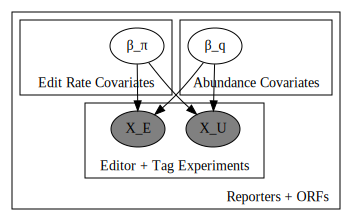

In [4]:
def ppiseq_model(data):
    n_exps, n_orfs = data["reads_edited"].shape
    n_q_covs = data["q_design_matrix"].shape[1]
    n_pi_covs = data["pi_design_matrix"].shape[1]

    with pyro.plate("Reporters + ORFs", n_orfs):
        with pyro.plate("Abundance Covariates", n_q_covs):
            betas_q = pyro.sample("β_q", dist.Normal(0, 1))

        with pyro.plate("Edit Rate Covariates", n_pi_covs):
            betas_pi = pyro.sample("β_π", dist.Normal(0, 1))

        with pyro.plate("Editor + Tag Experiments", n_exps):
            # TODO dispersion sampling possibly
            # dispersion = pyro.sample(
            #     "φ", dist.LogNormal(data["fit_dispersions"].log(), dispersion_var)
            # )

            log_q = data["q_design_matrix"].float() @ betas_q
            # * this needs to be a bit more convincing to me
            pi = (data["pi_design_matrix"].float() @ betas_pi).sigmoid()

            logits_U = (
                log_q
                + -pi.logit()
                + data["size_factors"].log()
                - data["fit_dispersions"].log()
            )
            logits_E = (
                log_q
                + pi.logit()
                + data["size_factors"].log()
                - data["fit_dispersions"].log()
            )

            dist_U = dist.NegativeBinomial(data["fit_dispersions"], logits=logits_U) # type: ignore
            dist_E = dist.NegativeBinomial(data["fit_dispersions"], logits=logits_E) # type: ignore

            pyro.sample("X_U", dist_U, obs=data["reads_unedited"])
            pyro.sample("X_E", dist_E, obs=data["reads_edited"])


pyro.render_model(ppiseq_model, model_args=(data,), render_params=True)


In [16]:
guide = AutoNormal(ppiseq_model, init_scale=0.01)

pyro.clear_param_store()
initial_lr = 0.05
gamma = 0.1  # final learning rate will be gamma * initial_lr
num_steps = 2000
lr_decay = gamma ** (1 / num_steps)
svi = pyro.infer.SVI(
    model=ppiseq_model,
    guide=guide,
    optim=pyro.optim.ClippedAdam({"lr": initial_lr, "lrd": lr_decay}),
    loss=pyro.infer.Trace_ELBO(),
)

results = defaultdict(list)

for _ in tqdm(range(num_steps)):
    results["losses"].append(svi.step(data))
    results["betas_q_mean"].append(pyro.param("AutoNormal.locs.β_q").clone())
    results["betas_q_var"].append(pyro.param("AutoNormal.scales.β_q").clone())
    results["betas_pi_mean"].append(pyro.param("AutoNormal.locs.β_π").clone())
    results["betas_pi_vars"].append(pyro.param("AutoNormal.scales.β_π").clone())

100%|██████████| 2000/2000 [00:22<00:00, 89.20it/s]


In [17]:
pyro.get_param_store().keys()

dict_keys(['AutoNormal.locs.β_q', 'AutoNormal.scales.β_q', 'AutoNormal.locs.β_π', 'AutoNormal.scales.β_π'])

Text(0, 0.5, 'loss')

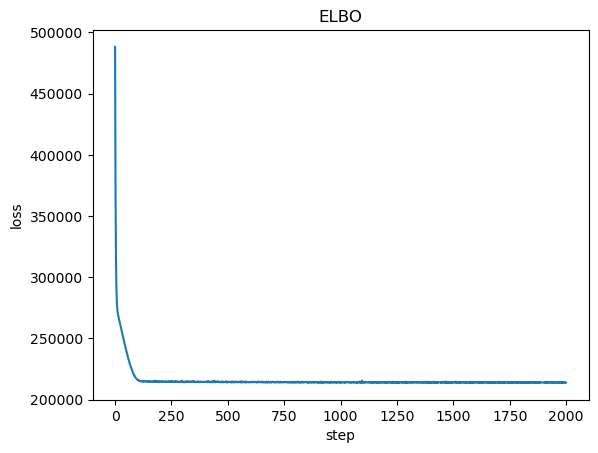

In [18]:
import matplotlib.pyplot as plt

plt.plot(results["losses"])
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
